In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from bayes_traj.pyro_helper import *

torch.set_default_dtype(torch.double)

# Read toy data and plot

In [5]:
df = pd.read_csv('4d_binary_20_visits.csv')
preds = ['intercept', 'x', 'x^2', 'x^3']
targets = ['y1']

Color-code data based on ground-truth trajectory assignment ('traj_gt')

Text(0, 0.5, 'y1')

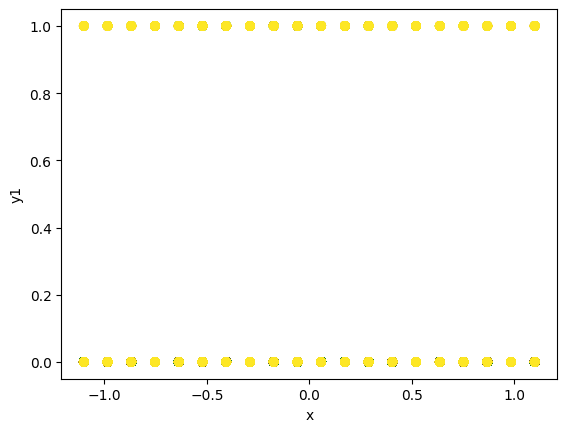

In [6]:
plt.scatter(df['x'], df['y1'], c=df['traj_gt'])
plt.xlabel('x')
plt.ylabel('y1')

# Fit to data

In [5]:
!bayes_traj_main --in_csv 4d_binary_20_visits.csv --targets y1 --groupby id --prior 4d_binary_20_visits_prior.p --verbose --iters 1000 --repeats 1 --use_pyro -k 3 --out_model foo_pyro.pt

Reading prior...
Reading data...
Fitting...
step    0 loss = 0.655
step  100 loss = 0.356
step  200 loss = 0.349
step  300 loss = 0.350
step  400 loss = 0.349
step  500 loss = 0.349
step  600 loss = 0.349
step  700 loss = 0.349
step  800 loss = 0.349
step  900 loss = 0.350
DONE.


# Inspect fit

In [7]:
model = torch.load('foo_pyro.pt')

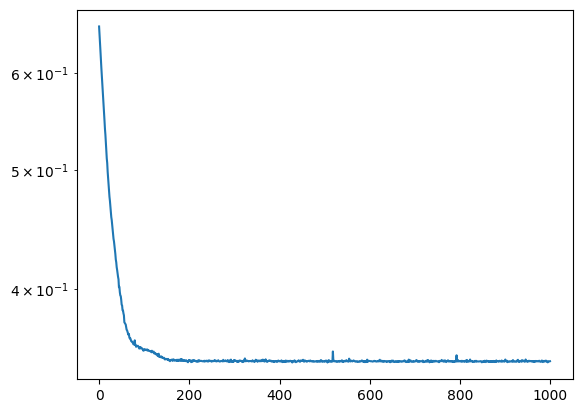

In [8]:
plt.plot(model.losses)
plt.yscale('log')

In [17]:
data = get_restructured_data(df, preds, targets, 'id')
X = data["X"]
X_mask = data["X_mask"]
Y_bool = data["Y_bool"]
Y_bool_mask = data["Y_bool_mask"]


           X: torch.Size([20, 400, 4])
      X_mask: torch.Size([20, 400])
      Y_real: n/a
 Y_real_mask: n/a
      Y_bool: torch.Size([20, 400, 1])
 Y_bool_mask: torch.Size([20, 400])


In [14]:
probs = model.classify(X, Y_bool=Y_bool, Y_bool_mask=Y_bool_mask)

In [15]:
print(np.sum(probs.numpy(), 0))

[124.86 139.19 135.95]


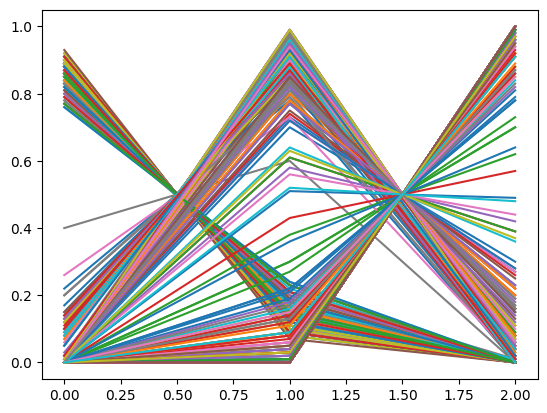

In [16]:
plt.plot(probs.T);

Overlap trajectories with data to inspect fit:

In [17]:
np.sum(probs.numpy(),0)

array([124.86, 139.19, 135.95])

In [18]:
np.argmax(probs.numpy(), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [19]:
df['traj_gt']

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
7995    3.0
7996    3.0
7997    3.0
7998    3.0
7999    3.0
Name: traj_gt, Length: 8000, dtype: float64

In [22]:
plt.close('all')


#plt.scatter(df['age'], df['y1'], c=df['traj_gt'])
plt.scatter(df['age'], df['y1'], c=np.argmax(probs.numpy(), axis=1))
plt.xlabel('age')
plt.ylabel('y1')

K = 5
X = torch.ones([100, 2])
X[:, 1] = torch.linspace(45, 90, 100)
for kk in range(K):
    w = model.params['params']['AutoNormal.locs.W_'][kk, 0].data.numpy()
    lambda_ = model.params['params']['AutoNormal.locs.lambda_'][kk].data
    stddev = lambda_.rsqrt().numpy()
    y1_tmp = np.dot(X.numpy(), w.T)
    plt.plot(X[:, 1], y1_tmp)
    lb = y1_tmp - 2*stddev
    ub = y1_tmp + 2*stddev
    plt.fill_between(X[:, 1], lb, ub, alpha=0.2)
plt.show()

KeyError: 'age'